# Tree Ensemble Models

## 1. Titanic Survial Classification Problem
- 본 실습에서는 타이타닉 생존 데이터를 이용하여
    - 데이터를 이해하고 전처리한 후
    - 앙상블 모델을 이용하여 생존한 탑승객들을 분류해보고자 합니다.

### (1) Load the data

In [1]:
# pandas 등 필요한 패키지를 불러온다.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 데이터 불러오기
data = pd.read_csv('./train.csv')

In [3]:
# 데이터의 크기와 모양을 확인한다.
print(data.shape)

(891, 12)


In [4]:
# 첫 5개의 데이터를 확인한다.
data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# 어떠한 변수가 데이터를 구성하고 있는지 살펴본다.
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### (2) Understand the data
- 다음은 데이터에 대한 이해를 바탕으로 기계학습 모델의 학습을 위해 필요하지 않은 변수와 타겟값 등을 파악해봅시다.
    - "PassengerID"와 "Name" 은 모델의 학습에 필요하지 않은 feature입니다.
    - "Ticket" 은 사용할 수도, 사용하지 않을 수도 있는 feature입니다.
    - "Survived"는 분류하고자 하는 타겟 변수입니다.
    - "Sex", "Age", "SibSp", "Parch", "Pclass" 등은 input으로 사용할 feature입니다.

### (3) Data Preprocessing
- 데이터 전처리 단계에서는 
    - 모델이 학습할 수 있는 형태로의 데이터 변환과 
    - 결측치를 처리해보도록 하겠습니다.

- 먼저 데이터를 변환해보도록 하겠습니다.
- 범주형(categorical) 변수인 "Sex" feature 를 수치형(numeric) 변수로 입력할 수 있도록 "male" 을 0으로, "female"을 1로 변환해보도록 하겠습니다. 

In [6]:
# male에 0, female에 1을 매핑(map)한다.
binary_vals = { "Sex": {"male": 0, "female": 1}}

In [7]:
# 위에서 정의한 방식으로 "Sex" 열의 데이터를 수치형으로 치환한다.
data.replace(binary_vals, inplace=True)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


- "Pclass" 변수의 경우, ordinal 변수로 취급할 지, nominal 변수로 취급할 지에 따라 인풋(input) feature로 사용할 수도, 사용하지 않을 수도 있습니다. 
- "Pclass" 변수를 구성하고 있는 데이터의 형태를 확인해봅시다.

In [8]:
# "Pclass" 변수에 값의 종류가 몇 가지 있는지 확인한다.
print(data.Pclass.unique())

[3 1 2]


- 범주형 변수를 수치형으로 변환하기만 하면 데이터간 관계성이 부여됩니다. 이는 모델 학습에 영향을 줄 수 수 있으므로 서로 독립적인 가변수로 변환하여 이러한 문제를 방지할 수 있습니다.

In [9]:
# 범주형 데이터를 pandas의 get_dummies 함수를 이용하여 가변수로 가공해봅시다.
pd.get_dummies(data, columns=["Pclass"]).head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,False,False,True
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,True,False,False
2,3,1,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,False,True
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,True,False,False
4,5,0,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,False,False,True


- 이를 통해 Pclass 변수를 input 변수로 활용할 수 있음을 확인했습니다.
- scikit-learn 의 train_test_split 함수를 이용하여 일정한 비율로 Train, Validation, Test 데이터를 나눠봅시다.

In [10]:
# 데이터셋의 레코드 값과 타겟 값을 불러와 각각 X, y 라는 이름으로 저장한다.

X = data[["Sex", "Age", "SibSp", "Parch", "Pclass"]]
y = data["Survived"]

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

- 다음으로, 결측치를 처리해보도록 하겠습니다. 
- 결측치를 포함한 데이터를 제거하는 방식과 결측치를 대체하는 방식 중에서 결측치를 대체(imputation)하는 방식을 사용해보도록 하겠습니다.
- 먼저 결측치가 아닌 데이터를 살펴봅시다.

In [12]:
# data = data[data['Age'].notnull()]

- sklearn 패키지의 SimpleImputer 함수를 이용하여 결측치를 대체해봅시다. 
- strategy 옵션을 mean으로 설정하여 결측치가 아닌 값들의 평균으로 결측치를 대체합니다.
- train, test 데이터셋 각각에 적용해봅시다.

In [13]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

X_train = X_train.copy(); X_val = X_val.copy(); X_test = X_test.copy()
X_train.loc[:,'Age'] = imp.fit_transform(X_train.loc[:,['Age']])
X_val.loc[:,'Age'] = imp.transform(X_val.loc[:,['Age']])
X_test.loc[:,'Age'] = imp.transform(X_test.loc[:,['Age']])

### (4) Train Classification Models
-  위를 통해 데이터 준비가 끝났으니, 의사결정나무 모델을 가져와 훈련하도록 합니다.
- 우선, scikit-learn에서 DecisionTreeClassifier 이란 이름의 분류의사결정나무 모델을 가져와 clf 라는 이름으로 정의하겠습니다.
- 훈련용 데이터를 이용하여 의사결정나무를 훈련(fit)합니다.

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

- 위를 통해 훈련이 완료되었습니다!
- 이제, predict 함수를 이용하여 Train set과 Validation set, test set 각각에 대해서 예측한 후 실제 값 y와 비교하여 모델의 성능을 평가해봅시다.
- 해당 예시에서 의사결정나무 모델은 분류 모델로 활용되었으므로, 분류를 위한 대표적인 평가 지표인 정확도(accuracy)를 구해보도록 하겠습니다.

In [15]:
from sklearn.metrics import accuracy_score

y_train_hat= clf.predict(X_train)
y_val_hat = clf.predict(X_val)
y_test_hat = clf.predict(X_test)
print(accuracy_score(y_train, y_train_hat))
print(accuracy_score(y_val, y_val_hat))
print(accuracy_score(y_test, y_test_hat))

0.9245585874799358
0.7686567164179104
0.7238805970149254


- 훈련된 의사결정나무 모델은 Train dataset 분류 정확도 92%, Validation set의 분류 정확도는 78%, test set의 분류 정확도 72% 의 성능을 보이는 것을 확인할 수 있습니다.

- 다음으로는 의사결정나무 모델을 시각화해보도록 하겠습니다. 
- export_text 함수를 이용하여 텍스트 형태로 의사결정나무 모델을 시각화해봅시다.

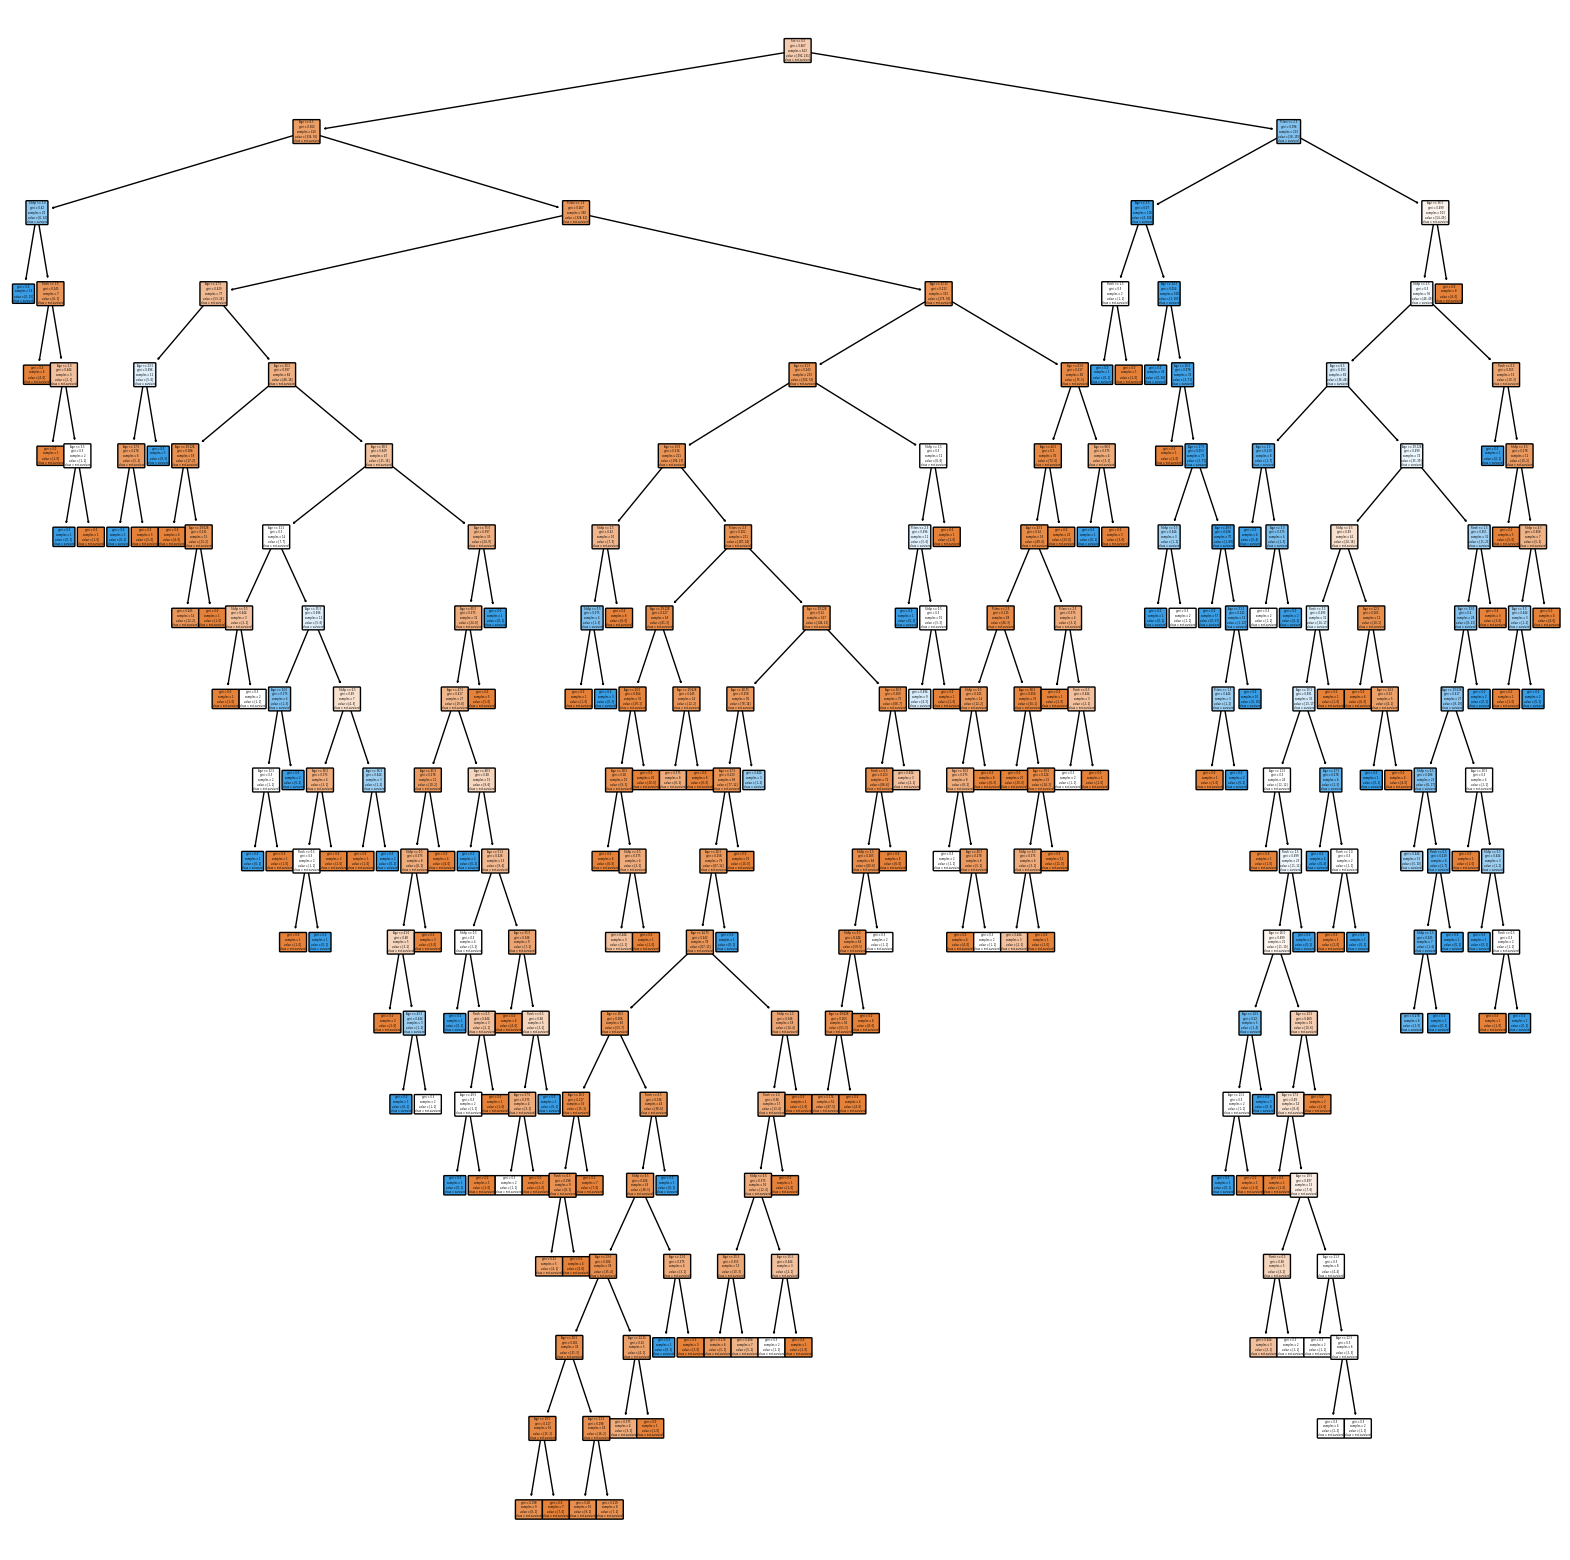

In [16]:
plt.figure(figsize=(20,20))
plt.show(tree.plot_tree(clf, 
                        feature_names = X_train.columns, 
                        class_names=['not-survived','survived'],
                        filled = True,rounded=True))

### (5) Hyperparameter Tuning
- 의사결정나무 모형의 최대 깊이(max_depth)에 따라 모델의 성능이 어떻게 달라질 수 있는지 확인해보도록 하겠습니다.

Text(0.5, 0, 'Tree Max depth')

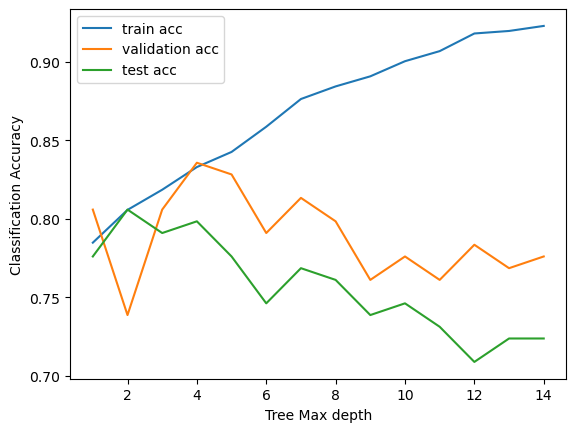

In [17]:
train_acc, val_acc, test_acc = [], [], []
depth_list = list(range(1,15))
for depth in depth_list : 
    model = DecisionTreeClassifier(max_depth=depth)
    model = model.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, model.predict(X_train)))
    val_acc.append(accuracy_score(y_val, model.predict(X_val)))
    test_acc.append(accuracy_score(y_test, model.predict(X_test)))

    #print(accuracy_score(y_train, model.predict(X_train)))
    #print(accuracy_score(y_test, model.predict(X_test)))
    
plt.plot(depth_list, train_acc)
plt.plot(depth_list, val_acc)
plt.plot(depth_list, test_acc)
plt.legend(['train acc','validation acc','test acc'])
plt.ylabel('Classification Accuracy')
plt.xlabel('Tree Max depth')

- 깊이가 깊어질수록 더 자세해지기 때문에 학습 데이터셋에 대한 정확도(train accuracy)는 증가하는 것을 확인할 수 있습니다.
- 반면, validataion, test accuracy는 점점 감소하므로 overfitting이 발생한다는 것을 확인할 수 있습니다. 
- Max Depth가 4 일 때 Validation accuracy 가 가장 높았으므로 이 때의 모델을 시각화해봅시다.

In [18]:
clf = DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X_train, y_train)

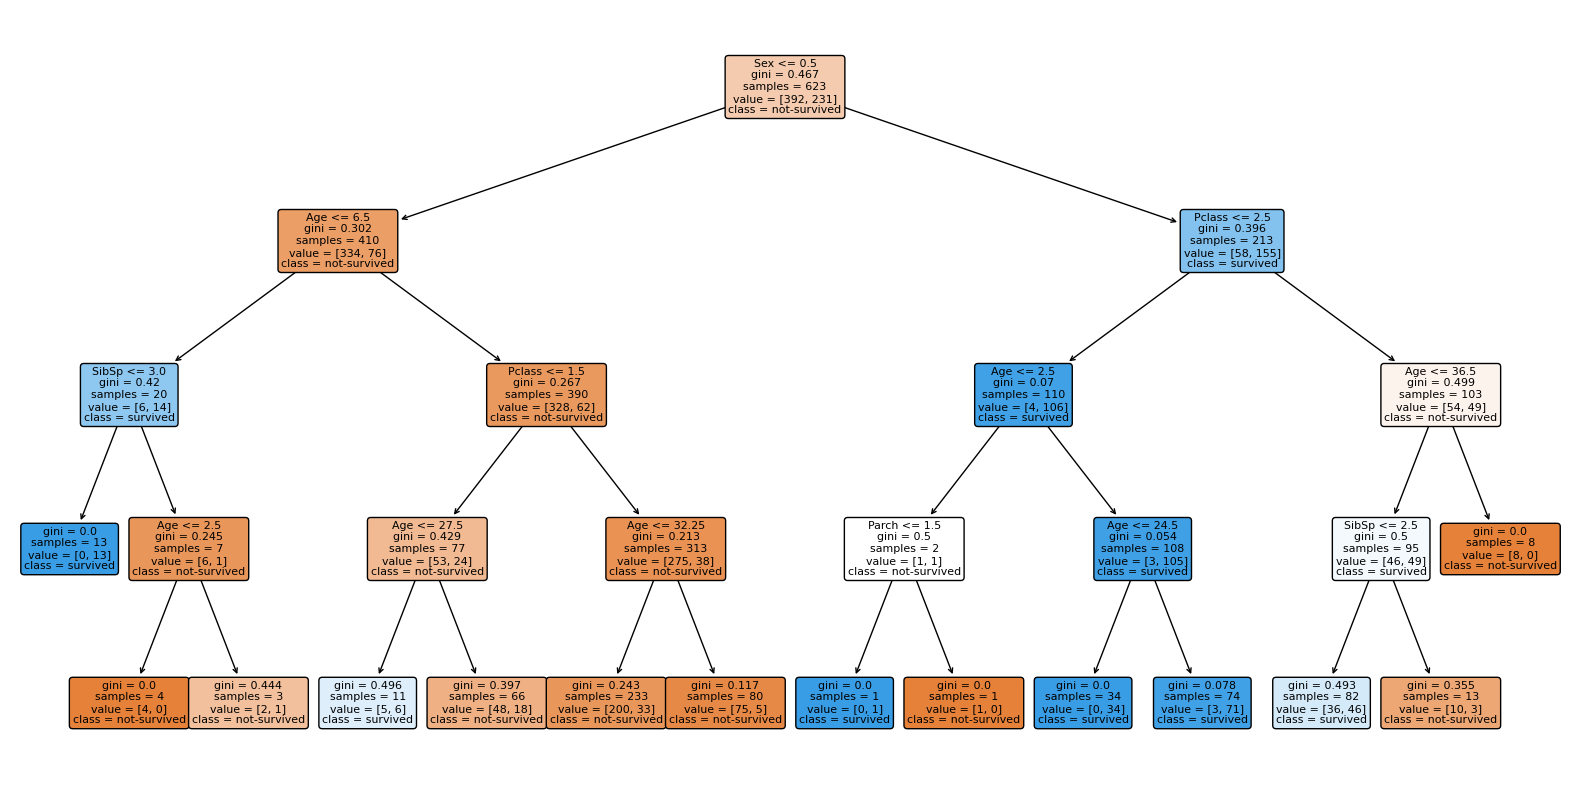

In [19]:
plt.figure(figsize=(20,10))
plt.show(tree.plot_tree(clf, 
                        feature_names = X_train.columns, 
                        class_names=['not-survived','survived'],
                        filled = True,rounded=True))

### (6) Feature Importance
- sklearn의 DecisionTreeClassifier 함수는 모델의 학습에 가장 주요하게 작용한 변수를 확인할 수 있습니다.
- feature_importances_함수를 이용하여 각 변수의 중요도를 확인해봅시다.
- (참고) https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_

In [20]:
# 각 변수의 중요도를 출력한다.
clf.feature_importances_

array([0.58507691, 0.13158278, 0.06479991, 0.00709536, 0.21144504])

In [21]:
# 모델 학습에 사용된 변수를 확인한다.
X.columns

Index(['Sex', 'Age', 'SibSp', 'Parch', 'Pclass'], dtype='object')

- 각 변수의 중요도를 시각화해봅시다.

Text(0, 0.5, 'Feature')

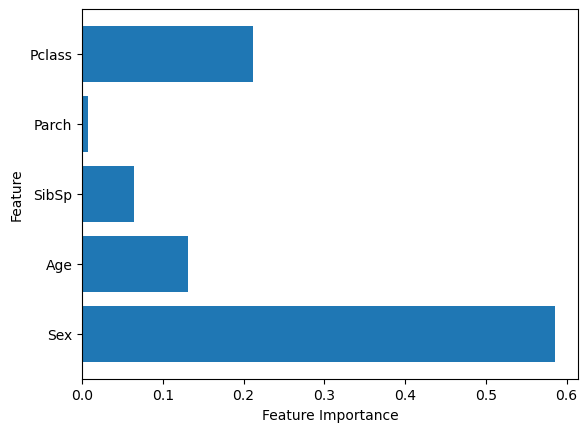

In [22]:
plt.barh(range(X.shape[1]),clf.feature_importances_,align='center')
plt.yticks(np.arange(X.shape[1]), X.columns)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")

## Ensemble Models
- 다음으로 앙상블 방법을 여러 모델의 예측을 결합함으로써 단일 의사결정나무의 일반화 가능성/강건성을 개선할 수 있습니다.
- 다음 4가지 앙상블 모델과 주요 hyperparameter을 알아봅시다.

### (1) Bagging
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
- bias-variance : https://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html#sphx-glr-auto-examples-ensemble-plot-bias-variance-py
- hyperparameters :
    - base_estimator (default : DecisionTreeClassifier)
    - n_estimators
### (2) AdaBoost

- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
- hyperparameters :
    - base_estimator (default : DecisionTreeClassifier)
    - n_estimators
### (3) Gradient Boosting

- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
- hyperparameters :
    - max_depth
### (4) Random Forest

- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- hyperparameters :
    - n_estimators
    - max_features (default : auto)
    - bootstrap (default : True)
    - max_depth

- 각각의 모델을 훈련하고 모델의 성능을 비교해봅시다.

### (1) Bagging
- 우선, scikit-learn에서 BaggingClassifier 이란 이름의 앙상블 모델을 가져와 clf 라는 이름으로 정의하겠습니다.
- 훈련용 데이터를 이용하여 의사결정나무를 훈련(fit)합니다.

In [23]:
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
clf = BaggingClassifier()
clf = clf.fit(X_train, y_train)

- 위를 통해 훈련이 완료되었습니다!
- 이제, predict 함수를 이용하여 Train dataset, Validation dataset과 test dataset 각각에 대해서 예측한 후 실제 값 y와 비교하여 모델의 성능을 평가해봅시다.
- 해당 예시에서 의사결정나무 모델은 분류 모델로 활용되었으므로, 분류를 위한 대표적인 평가 지표인 정확도(accuracy)를 구해보도록 하겠습니다.

In [24]:
from sklearn.metrics import accuracy_score

y_train_hat= clf.predict(X_train)
y_val_hat = clf.predict(X_val)
y_test_hat = clf.predict(X_test)
print(accuracy_score(y_train, y_train_hat))
print(accuracy_score(y_val, y_val_hat))
print(accuracy_score(y_test, y_test_hat))

0.9197431781701445
0.8134328358208955
0.7686567164179104


- Validation과 Test set에 대한 정확도가 단일 DecisionTreeClassifier을 이용했을 때보다 개선되었음을 확인할 수 있습니다.

### (2) AdaBoost
- Scikit-learn에서 AdaBoostClassifier 이란 이름의 앙상블 모델을 훈련한 후 Train, Validation, Test dataset 각각에 대해 모델의 성능을 평가해봅시다.

### (3) GradientBoost
- Scikit-learn에서 GradientBoostingClassifier 이란 이름의 앙상블 모델을 훈련한 후 Train,Validation,Test dataset 각각에 대해 모델의 성능을 평가해봅시다.

### (4) RandomForest
- Scikit-learn에서 RandomForestClassifier 이란 이름의 앙상블 모델을 훈련한 후 Train,Validation,Test dataset 각각에 대해 모델의 성능을 평가해봅시다.
- feature importance를 시각화해봅시다.

### (5) Xgboost
- xgboost에서 XGBClassifier 이란 이름의 앙상블 모델을 훈련한 후 Train,Validation,Test dataset 각각에 대해 모델의 성능을 평가해봅시다.
- feature importance를 시각화해봅시다.
- 모델을 plot_tree 함수를 이용하여 시각화해봅시다.

In [25]:
!pip install xgboost

- 훈련용 데이터를 이용하여 의사결정나무를 훈련(fit)합니다.

In [26]:
from xgboost import XGBClassifier
import xgboost as xgb
clf = xgb.XGBClassifier()
clf = clf.fit(X_train, y_train)

- predict 함수를 이용하여 Train dataset과 Validation, Test dataset 각각에 대해서 예측한 후 실제 값 y와 비교하여 모델의 성능을 평가해봅시다.
- 해당 예시에서 XGBoost 모델은 분류 모델로 활용되었으므로, 분류를 위한 대표적인 평가 지표인 정확도(accuracy)를 구해보도록 하겠습니다.

In [27]:
from sklearn.metrics import accuracy_score

y_train_hat= clf.predict(X_train)
y_val_hat = clf.predict(X_val)
y_test_hat = clf.predict(X_test)
print(accuracy_score(y_train, y_train_hat))
print(accuracy_score(y_val, y_val_hat))
print(accuracy_score(y_test, y_test_hat))

0.9036918138041734
0.8283582089552238
0.8134328358208955


- xgb의 plot_importance 함수를 이용하여 주요 feature를 시각화해봅시다.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

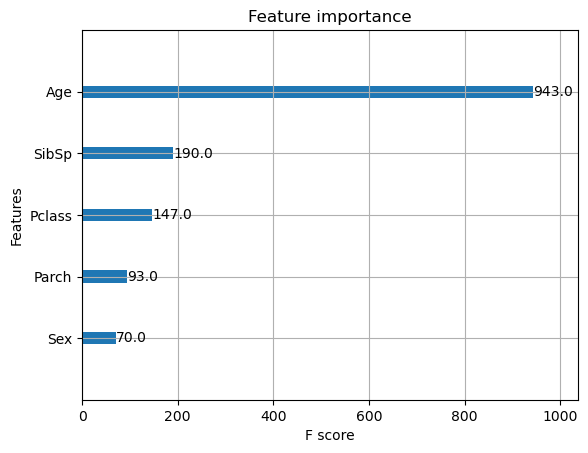

In [28]:
xgb.plot_importance(clf)

# Cross Validation
- Bagging Classifier 모델에 교차 검증(Cross-validation)을 적용해봅시다.
- 교차 검증(Cross-validation)은 주어진 데이터를 여러 개의 부분집합으로 나눈 후, 각 부분집합을 차례로 테스트 데이터로 사용하고 나머지 부분집합을 훈련 데이터로 사용하여 모델을 학습시킴으로써 머신 러닝 모델의 성능을 평가하고 모델의 일반화 능력을 확인할 수 있습니다.
- 교차 검증은 모델의 성능을 더 정확하게 평가할 수 있도록 도와주며, 과적합(overfitting) 방지 및 hyperparameter tuning에 활용할 수 있습니다.
- (참고) https://scikit-learn.org/stable/modules/cross_validation.html
- (참고) https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score

In [29]:
# scikit-learn 의 train_test_split 함수를 이용하여 일정한 비율로 Train, Test 데이터를 나눈다.
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [30]:
# sklearn 패키지의 SimpleImputer 함수를 이용하여 결측치를 대체한다. 
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

X_train = X_train.copy(); X_test = X_test.copy()
X_train.loc[:,'Age'] = imp.fit_transform(X_train.loc[:,['Age']])
X_test.loc[:,'Age'] = imp.transform(X_test.loc[:,['Age']])

- BaggingClassifier 모델에 cross_val_score 함수를 적용하여 총 5개 fold 의 5-fold Cross Validation을 수행하고, 결과값의 평균과 표준편차를 확인해봅시다.

In [31]:
clf = BaggingClassifier()
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.8        0.768      0.744      0.73387097 0.81451613]
0.77 accuracy with a standard deviation of 0.03
